In [5]:
from dotenv import load_dotenv
import os

In [8]:
import cassio  #python 3.12 issue
load_dotenv()
#connection to the astradb
astradb_token = os.environ['ASTRADB_API_TOKEN']
astradb_id = os.environ['ASTRADB_ID']
cassio.init(token=astradb_token, database_id=astradb_id)

Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7


ValueError: Generic error when fetching the URL to the secure-bundle.

In [9]:
#build index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    
]

In [ ]:
#load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [ ]:
#split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap = 0
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
doc_splits

In [48]:
from langchain_huggingface import HuggingFaceEmbeddings
# from google.colab import userdata
# access_token = userdata.get('HF_TOKEN')
# print(access_token)
# model_name = "all-MiniLM-L12-v2"

In [49]:
embeddings = HuggingFaceEmbeddings()

OSError: [WinError 126] The specified module could not be found. Error loading "d:\a27_YEARS_OLD\multiagent_rag\venv\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [44]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

NameError: name 'embeddings' is not defined

In [42]:
from langchain.indexes.vectorstore import VectorstoreIndexCreator, VectorStoreIndexWrapper

In [43]:
astra_vector_store.add_documents(doc_splits)
print(f"Inserted {len(doc_splits)} headlines", )

NameError: name 'astra_vector_store' is not defined

In [ ]:
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

In [41]:
retriever = astra_vector_store.as_retriever()
retriever.invoke("what is agent ?")

NameError: name 'astra_vector_store' is not defined

In [1]:
## langgraph application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [23]:
# Data model
class RouteQuery(BaseModel):
  """ Route a user query to the most relevant dataset."""
  datasource:Literal["vectorstore", "wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

In [24]:

groq_api_key = os.environ['GROQ_API_KEY']

In [25]:
from langchain_groq import ChatGroq

In [26]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name = "llama-3.1-70b-Versatile")

In [27]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [28]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

In [29]:
print(question_router.invoke(
    {
        'question': "what is agent ?"
    }
))

datasource='vectorstore'


In [30]:
print(question_router.invoke(
    {
        'question': "who is sharukh khan ?"
    }
))

datasource='wiki_search'


In [31]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [32]:
api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper)

In [33]:
wiki.run("tell me about srk.")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refe'

In [34]:
## ai agent application using langgraph
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]





In [35]:
from langchain.schema import document

def retrieve(state):
    """
    Retrieves documents

    Args:
        state (dict): The current state of the conversation graph

    Returns::
        state (dict): New key added to state, documents, that contains retrieved documents

    """
    print("---Retrieve---")
    questions = state['question']

    ## Retrieval
    documents = retriever.invoke(questions)
    return {"documents":documents, "questions":questions}

In [36]:
from langchain.schema import Document

def wiki_search(state):
    """
    Retrieves documents

    Args:
        state (dict): The current state of the conversation graph

    Returns::
        state (dict): New key added to state, documents, that contains retrieved documents

    """
    print("---wikipedia---")
    questions = state['question']
    print(questions)

    ## wiki search
    docs = wiki.invoke({"query":questions})
    wiki_results = docs
    wiki_results = Document(page_content = wiki_results)
    return {"documents": wiki_results, "questions":questions}

In [37]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [38]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

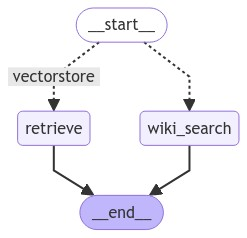

In [39]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---


NameError: name 'retriever' is not defined

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation